<a href="https://www.kaggle.com/code/rogerdias/m2-lof-iso-roger-quinelato?scriptVersionId=271823114" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# PIPELINE DUAL: LOF + ISOLATION FOREST - COMPARAÇÃO COMPLETA
# ============================================================================
# CÉLULA 1: IMPORTS E SETUP

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

print("PIPELINE DUAL: LOF + ISOLATION FOREST")
print("=" * 80)
print(f"\nData/Hora: {pd.Timestamp.now()}\n")

PIPELINE DUAL: LOF + ISOLATION FOREST

Data/Hora: 2025-10-29 13:45:39.698795



In [2]:
# CÉLULA 2: LEITURA E PRÉ-PROCESSAMENTO BÁSICO
# ============================================================================
print("CÉLULA 2: Leitura e Pré-processamento")
print("-" * 80)

caminho = '/kaggle/input/m2-data/M2.rpt'
start = time.time()

df = pd.read_fwf(caminho)

cabecalho = df.iloc[1].tolist()
cabecalho[0] = 'veiculo'
cabecalho[7] = 'speed'
cabecalho[8] = 'odometer'
df = df.drop([0, 1, 2]).reset_index(drop=True)
df.columns = cabecalho
df.columns.name = None
df = df.drop(df.index[-1]).reset_index(drop=True)

cols_numericas = ['Longitude', 'Latitude', 'altitude', 'angle', 'speed', 'odometer', 'satellites']
for col in cols_numericas:
    df[col] = df[col].astype(str).str.replace(',', '.').str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['data'] = pd.to_datetime(df['utcdate'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df.drop('utcdate', axis=1, inplace=True)
df['date'] = df['data'].dt.date

print(f"✓ Dados carregados: {len(df):,} registros")
print(f"✓ Tempo: {time.time() - start:.2f}s\n")

CÉLULA 2: Leitura e Pré-processamento
--------------------------------------------------------------------------------
✓ Dados carregados: 1,000,000 registros
✓ Tempo: 22.01s



In [3]:
# CÉLULA 3: FILTRO DE FREQUÊNCIA
# ============================================================================
print("CÉLULA 3: Filtro de Frequência")
print("-" * 80)

frequencia = df['veiculo'].value_counts()
veiculos_validos = frequencia[frequencia >= 11].index.tolist()
df_antes = len(df)
df = df[df['veiculo'].isin(veiculos_validos)].copy().reset_index(drop=True)

print(f"Antes:  {len(frequencia):,} veículos, {df_antes:,} registros")
print(f"Depois: {len(df['veiculo'].unique()):,} veículos, {len(df):,} registros")
print(f"Retido: {len(df)/df_antes*100:.1f}%\n")

CÉLULA 3: Filtro de Frequência
--------------------------------------------------------------------------------
Antes:  22,086 veículos, 1,000,000 registros
Depois: 17,844 veículos, 973,261 registros
Retido: 97.3%



In [4]:
# CÉLULA 4: ENGENHARIA DE FEATURES (OTIMIZADA)
# ============================================================================
print("CÉLULA 4: Engenharia de Features")
print("-" * 80)

start_features = time.time()
df = df.sort_values(['veiculo', 'data']).reset_index(drop=True)

print("  [1/6] Distância Haversine...")
start = time.time()

def haversine_vectorized(df):
    lat1 = np.radians(df['Latitude'].shift(1).values)
    lat2 = np.radians(df['Latitude'].values)
    lon1 = np.radians(df['Longitude'].shift(1).values)
    lon2 = np.radians(df['Longitude'].values)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distancia = 6371 * c
    
    veiculo_changed = df['veiculo'].values != df['veiculo'].shift(1).values
    distancia[veiculo_changed] = 0
    
    return distancia

df['distancia_km'] = haversine_vectorized(df)
print(f"        ✓ {time.time() - start:.2f}s")

print("  [2/6] Delta de tempo...")
start = time.time()
df['delta_tempo_s'] = df.groupby('veiculo')['data'].diff().dt.total_seconds().fillna(0).values
print(f"        ✓ {time.time() - start:.2f}s")

print("  [3/6] Aceleração...")
start = time.time()
df['delta_speed'] = df.groupby('veiculo')['speed'].diff().fillna(0).values
df['aceleracao'] = np.where(df['delta_tempo_s'] > 0, 
                             df['delta_speed'] / df['delta_tempo_s'], 
                             0)
df['aceleracao'] = np.clip(df['aceleracao'], -50, 50)
print(f"        ✓ {time.time() - start:.2f}s")

print("  [4/6] Inconsistência Speed/Status...")
start = time.time()
df['inconsistencia_status'] = 0
df.loc[(df['engineStatus'] == 'parked') & (df['speed'] > 2), 'inconsistencia_status'] = 1
df.loc[(df['engineStatus'] == 'idling') & (df['speed'] > 5), 'inconsistencia_status'] = 1
df.loc[(df['engineStatus'] == 'motion') & (df['speed'] < 1), 'inconsistencia_status'] = 1
print(f"        ✓ {time.time() - start:.2f}s")

print("  [5/6] Variação de Satélites...")
start = time.time()
df['delta_satellites'] = df.groupby('veiculo')['satellites'].diff().fillna(0).abs().values
print(f"        ✓ {time.time() - start:.2f}s")

print("  [6/6] Encoding Categórico (pd.get_dummies)...")
start = time.time()
df_encoded = pd.get_dummies(df, columns=['engineStatus'], prefix='status', drop_first=True)
print(f"        ✓ {time.time() - start:.2f}s")

print(f"\n✓ Features criadas em {time.time() - start_features:.2f}s")

CÉLULA 4: Engenharia de Features
--------------------------------------------------------------------------------
  [1/6] Distância Haversine...
        ✓ 0.10s
  [2/6] Delta de tempo...
        ✓ 0.12s
  [3/6] Aceleração...
        ✓ 0.13s
  [4/6] Inconsistência Speed/Status...
        ✓ 0.25s
  [5/6] Variação de Satélites...
        ✓ 0.10s
  [6/6] Encoding Categórico (pd.get_dummies)...
        ✓ 0.35s

✓ Features criadas em 1.70s


In [5]:
# CÉLULA 5: SELEÇÃO E PREPARAÇÃO DE FEATURES (VARIÁVEIS GLOBAIS)
# ============================================================================
print("CÉLULA 5: Seleção de Features e Preparação Global")
print("=" * 80)

# VARIÁVEIS GLOBAIS - Usadas por ambos os modelos
FEATURES_NUMERICAS = [
    'Longitude', 'Latitude', 'altitude', 'angle',
    'speed', 'satellites', 'distancia_km', 
    'aceleracao', 'inconsistencia_status', 'delta_satellites'
]

# Adicionar colunas de status encodadas
status_cols = [col for col in df_encoded.columns if col.startswith('status_')]
FEATURES_FINAIS = FEATURES_NUMERICAS + status_cols

print(f"\n✓ Features selecionadas: {len(FEATURES_FINAIS)}")
print(f"  Numéricas: {', '.join(FEATURES_NUMERICAS)}")
print(f"  Categóricas: {', '.join(status_cols)}")

# Preparar dataset para modelagem
df_modelo = df_encoded[FEATURES_FINAIS].copy()
df_modelo = df_modelo.fillna(df_modelo.mean(numeric_only=True))
df_modelo = df_modelo.replace([np.inf, -np.inf], np.nan)
df_modelo = df_modelo.fillna(df_modelo.mean(numeric_only=True))

print(f"\n✓ Dataset preparado:")
print(f"  Registros: {len(df_modelo):,}")
print(f"  Features: {len(FEATURES_FINAIS)}")
print(f"  Missing values: {df_modelo.isnull().sum().sum()}")

CÉLULA 5: Seleção de Features e Preparação Global

✓ Features selecionadas: 12
  Numéricas: Longitude, Latitude, altitude, angle, speed, satellites, distancia_km, aceleracao, inconsistencia_status, delta_satellites
  Categóricas: status_motion, status_parked

✓ Dataset preparado:
  Registros: 973,261
  Features: 12
  Missing values: 0


CÉLULA 6: Análise de Correlação entre Features

Features com correlação > 0.7 (excluindo diagonal):
  status_motion ↔ status_parked: -0.710


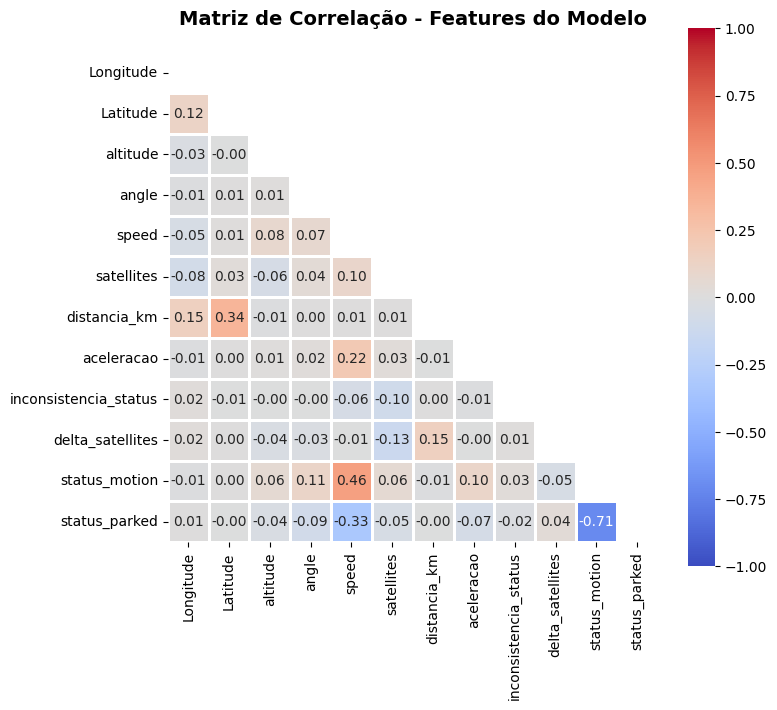


✓ Matriz de correlação exibida


In [6]:
# CÉLULA 6: MATRIZ DE CORRELAÇÃO
# ============================================================================

print("CÉLULA 6: Análise de Correlação entre Features")
print("=" * 80)

matriz_corr = df_modelo.corr()

# Identificar correlações altas
print("\nFeatures com correlação > 0.7 (excluindo diagonal):")
corr_alta_encontrada = False
for i in range(len(matriz_corr.columns)):
    for j in range(i+1, len(matriz_corr.columns)):
        if abs(matriz_corr.iloc[i, j]) > 0.7:
            print(f"  {matriz_corr.columns[i]} ↔ {matriz_corr.columns[j]}: {matriz_corr.iloc[i, j]:.3f}")
            corr_alta_encontrada = True

if not corr_alta_encontrada:
    print("  ✓ Nenhuma correlação excessiva detectada!")

# Gráfico: Heatmap de Correlação
fig, ax = plt.subplots(figsize=(8, 8))
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
sns.heatmap(matriz_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": .8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Matriz de Correlação - Features do Modelo', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()
print("\n✓ Matriz de correlação exibida")


In [7]:
# CÉLULA 7: NORMALIZAÇÃO (VARIÁVEL GLOBAL)
# ============================================================================
print("CÉLULA 7: Normalização (StandardScaler)")
print("=" * 80)

start = time.time()
scaler = StandardScaler()
FEATURES_NORMALIZED = scaler.fit_transform(df_modelo.values)

print(f"\n✓ Normalização concluída:")
print(f"  Shape: {FEATURES_NORMALIZED.shape}")
print(f"  Tempo: {time.time() - start:.2f}s")
print(f"  Mean (após normalização): {FEATURES_NORMALIZED.mean():.6f}")
print(f"  Std (após normalização): {FEATURES_NORMALIZED.std():.6f}\n")

CÉLULA 7: Normalização (StandardScaler)

✓ Normalização concluída:
  Shape: (973261, 12)
  Tempo: 1.35s
  Mean (após normalização): 0.000000
  Std (após normalização): 1.000000



In [8]:
# CÉLULA 8: MODELO 1 - LOCAL OUTLIER FACTOR (LOF)
# ============================================================================
print("CÉLULA 8: Modelo 1 - Local Outlier Factor (LOF)")
print("=" * 80)

start_lof = time.time()

lof = LocalOutlierFactor(
    n_neighbors=10,
    contamination=0.05,
    n_jobs=-1,
    novelty=False
)

lof_prediction = lof.fit_predict(FEATURES_NORMALIZED)
lof_score = lof.negative_outlier_factor_

tempo_lof = time.time() - start_lof
tempo_min = tempo_lof/60

# Adicionar ao dataframe
df_encoded['lof_prediction'] = lof_prediction
df_encoded['lof_score'] = lof_score

# Estatísticas
anomalias_lof = (lof_prediction == -1).sum()
normais_lof = (lof_prediction == 1).sum()
pct_lof = (anomalias_lof / len(df_encoded)) * 100

print("\n" + "-" * 80)
print("RESULTADOS LOF")
print("-" * 80)
print(f"\nTotal: {len(df_encoded):,} registros")
print(f"Anomalias: {anomalias_lof:,} ({pct_lof:.2f}%)")
print(f"Normais: {normais_lof:,} ({100-pct_lof:.2f}%)")
print(f"\nTempo: {tempo_min:.2f}m")
print(f"Velocidade: {len(df_encoded)/tempo_lof:,.0f} registros/s\n")

CÉLULA 8: Modelo 1 - Local Outlier Factor (LOF)

--------------------------------------------------------------------------------
RESULTADOS LOF
--------------------------------------------------------------------------------

Total: 973,261 registros
Anomalias: 48,663 (5.00%)
Normais: 924,598 (95.00%)

Tempo: 30.04m
Velocidade: 540 registros/s



**CÉLULA DEMORA QUASE 30 MIN MESMO COM n_neighbors=10**

In [9]:
# CÉLULA 9: MODELO 2 - ISOLATION FOREST
# ============================================================================
print("CÉLULA 9: Modelo 2 - Isolation Forest")
print("=" * 80)

start_iso = time.time()

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1,
    max_samples='auto',
    max_features=1.0
)

iso_prediction = iso.fit_predict(FEATURES_NORMALIZED)
iso_score = iso.score_samples(FEATURES_NORMALIZED)

tempo_iso = time.time() - start_iso

# Adicionar ao dataframe
df_encoded['iso_prediction'] = iso_prediction
df_encoded['iso_score'] = iso_score

# Estatísticas
anomalias_iso = (iso_prediction == -1).sum()
normais_iso = (iso_prediction == 1).sum()
pct_iso = (anomalias_iso / len(df_encoded)) * 100

print("\n" + "-" * 80)
print("RESULTADOS ISOLATION FOREST")
print("-" * 80)
print(f"\nTotal: {len(df_encoded):,} registros")
print(f"Anomalias: {anomalias_iso:,} ({pct_iso:.2f}%)")
print(f"Normais: {normais_iso:,} ({100-pct_iso:.2f}%)")
print(f"\nTempo: {tempo_iso:.2f}s")
print(f"Velocidade: {len(df_encoded)/tempo_iso:,.0f} registros/s")
print(f"\n⚡ Speedup: {tempo_lof/tempo_iso:.1f}x mais rápido que LOF\n")

CÉLULA 9: Modelo 2 - Isolation Forest

--------------------------------------------------------------------------------
RESULTADOS ISOLATION FOREST
--------------------------------------------------------------------------------

Total: 973,261 registros
Anomalias: 48,663 (5.00%)
Normais: 924,598 (95.00%)

Tempo: 93.12s
Velocidade: 10,452 registros/s

⚡ Speedup: 19.4x mais rápido que LOF



CÉLULA 10: Comparação LOF vs Isolation Forest
ANÁLISE DE CONCORDÂNCIA
--------------------------------------------------------------------------------

Concordância total: 891,765 registros (91.63%)

Detalhamento:
  Ambos detectaram anomalia: 7,915
  Ambos detectaram normal: 883,850
  Apenas LOF detectou: 40,748
  Apenas Isolation Forest detectou: 40,748
MATRIZ DE CONFUSÃO: Isolation Forest vs LOF
--------------------------------------------------------------------------------

         Predito ISO
         Normal  Anomalia
Real LOF
Normal    883850     40748
Anomalia   40748      7915


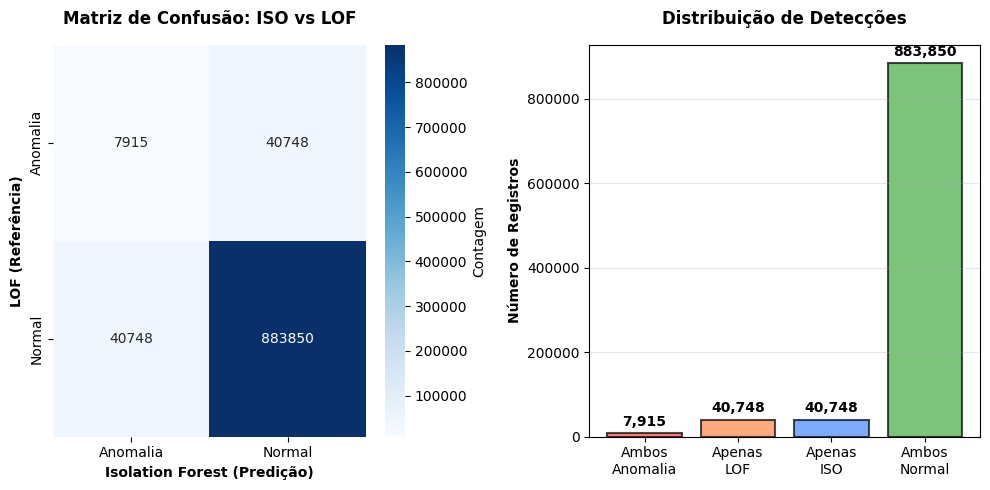


✓ Gráficos de comparação exibidos


In [10]:
# CÉLULA 10: COMPARAÇÃO ENTRE MODELOS
# ============================================================================
print("CÉLULA 10: Comparação LOF vs Isolation Forest")
print("=" * 80)

# Concordância entre modelos
concordancia = (df_encoded['lof_prediction'] == df_encoded['iso_prediction']).sum()
pct_concordancia = (concordancia / len(df_encoded)) * 100

# Análise detalhada
ambos_anomalia = ((df_encoded['lof_prediction'] == -1) & (df_encoded['iso_prediction'] == -1)).sum()
ambos_normal = ((df_encoded['lof_prediction'] == 1) & (df_encoded['iso_prediction'] == 1)).sum()
apenas_lof = ((df_encoded['lof_prediction'] == -1) & (df_encoded['iso_prediction'] == 1)).sum()
apenas_iso = ((df_encoded['lof_prediction'] == 1) & (df_encoded['iso_prediction'] == -1)).sum()

print("ANÁLISE DE CONCORDÂNCIA")
print("-" * 80)
print(f"\nConcordância total: {concordancia:,} registros ({pct_concordancia:.2f}%)")
print(f"\nDetalhamento:")
print(f"  Ambos detectaram anomalia: {ambos_anomalia:,}")
print(f"  Ambos detectaram normal: {ambos_normal:,}")
print(f"  Apenas LOF detectou: {apenas_lof:,}")
print(f"  Apenas Isolation Forest detectou: {apenas_iso:,}")

# Matriz de Confusão (LOF como "verdade" para comparação)
print("MATRIZ DE CONFUSÃO: Isolation Forest vs LOF")
print("-" * 80)

# Converter -1 para 0 (anomalia) e 1 para 1 (normal) para melhor visualização
lof_binary = (df_encoded['lof_prediction'] == 1).astype(int)
iso_binary = (df_encoded['iso_prediction'] == 1).astype(int)

cm = confusion_matrix(lof_binary, iso_binary)

print("\n         Predito ISO")
print("         Normal  Anomalia")
print(f"Real LOF")
print(f"Normal    {cm[1,1]:6d}  {cm[1,0]:8d}")
print(f"Anomalia  {cm[0,1]:6d}  {cm[0,0]:8d}")

# Visualizar Matriz de Confusão
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Anomalia', 'Normal'],
            yticklabels=['Anomalia', 'Normal'],
            cbar_kws={'label': 'Contagem'})
axes[0].set_xlabel('Isolation Forest (Predição)', fontweight='bold')
axes[0].set_ylabel('LOF (Referência)', fontweight='bold')
axes[0].set_title('Matriz de Confusão: ISO vs LOF', fontweight='bold', pad=15)

# Diagrama de Venn (conceitual)
categorias = ['Ambos\nAnomalia', 'Apenas\nLOF', 'Apenas\nISO', 'Ambos\nNormal']
valores = [ambos_anomalia, apenas_lof, apenas_iso, ambos_normal]
cores = ['#FF4444', '#FF8844', '#4488FF', '#44AA44']

axes[1].bar(categorias, valores, color=cores, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Número de Registros', fontweight='bold')
axes[1].set_title('Distribuição de Detecções', fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(valores):
    axes[1].text(i, v + max(valores)*0.02, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
print("\n✓ Gráficos de comparação exibidos")

CÉLULA 11: Análise por Veículo - LOF vs Isolation Forest

Top 10 veículos - LOF:
 1. Veículo 21536:   18 anomalias (45.00%)
 2. Veículo 18183:   17 anomalias (14.66%)
 3. Veículo 15154:   17 anomalias (13.49%)
 4. Veículo 17219:   16 anomalias (14.04%)
 5. Veículo 17342:   16 anomalias (13.33%)
 6. Veículo 12850:   16 anomalias (16.49%)
 7. Veículo 17497:   16 anomalias (10.88%)
 8. Veículo 16856:   16 anomalias (15.84%)
 9. Veículo 16745:   16 anomalias (13.91%)
10. Veículo 17465:   16 anomalias (13.01%)

Top 10 veículos - Isolation Forest:
 1. Veículo 21975:   42 anomalias (63.64%)
 2. Veículo 21867:   32 anomalias (66.67%)
 3. Veículo 9429:   32 anomalias (43.84%)
 4. Veículo 7422:   31 anomalias (65.96%)
 5. Veículo 22031:   31 anomalias (50.82%)
 6. Veículo 7424:   30 anomalias (73.17%)
 7. Veículo 22020:   30 anomalias (55.56%)
 8. Veículo 5432:   28 anomalias (75.68%)
 9. Veículo 7638:   28 anomalias (65.12%)
10. Veículo 7640:   26 anomalias (61.90%)


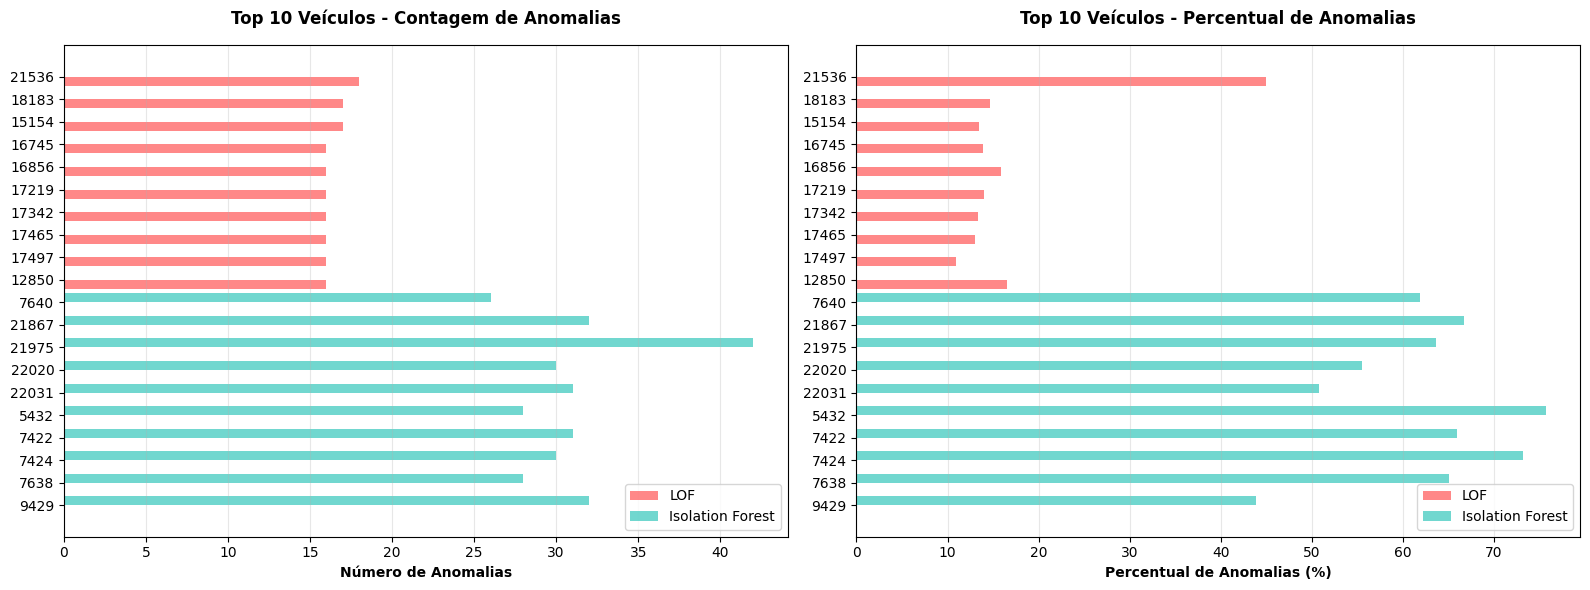


✓ Gráficos de análise por veículo exibidos


In [11]:
# CÉLULA 11: ANÁLISE POR VEÍCULO - AMBOS OS MODELOS
# ============================================================================
print("CÉLULA 11: Análise por Veículo - LOF vs Isolation Forest")
print("=" * 80)

# LOF
anomalias_veiculo_lof = df_encoded[df_encoded['lof_prediction'] == -1].groupby('veiculo').size()
total_veiculo = df_encoded.groupby('veiculo').size()
pct_veiculo_lof = (anomalias_veiculo_lof / total_veiculo * 100).sort_values(ascending=False)

# Isolation Forest
anomalias_veiculo_iso = df_encoded[df_encoded['iso_prediction'] == -1].groupby('veiculo').size()
pct_veiculo_iso = (anomalias_veiculo_iso / total_veiculo * 100).sort_values(ascending=False)

print("\nTop 10 veículos - LOF:")
for idx, (veiculo, count) in enumerate(anomalias_veiculo_lof.sort_values(ascending=False).head(10).items(), 1):
    pct = pct_veiculo_lof[veiculo]
    print(f"{idx:2d}. Veículo {veiculo}: {count:4d} anomalias ({pct:5.2f}%)")

print("\nTop 10 veículos - Isolation Forest:")
for idx, (veiculo, count) in enumerate(anomalias_veiculo_iso.sort_values(ascending=False).head(10).items(), 1):
    pct = pct_veiculo_iso[veiculo]
    print(f"{idx:2d}. Veículo {veiculo}: {count:4d} anomalias ({pct:5.2f}%)")

# Comparação visual
top10_lof = pd.DataFrame({
    'lof': anomalias_veiculo_lof,
    'pct_lof': pct_veiculo_lof
}).sort_values('lof', ascending=False).head(10)

top10_iso = pd.DataFrame({
    'iso': anomalias_veiculo_iso,
    'pct_iso': pct_veiculo_iso
}).sort_values('iso', ascending=False).head(10)

# Juntar dados
comparacao_veiculos = top10_lof.join(top10_iso, how='outer').fillna(0)
comparacao_veiculos = comparacao_veiculos.sort_values('lof', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Contagem
y_pos = np.arange(len(comparacao_veiculos))
axes[0].barh(y_pos - 0.2, comparacao_veiculos['lof'], height=0.4, 
             label='LOF', color='#FF6B6B', alpha=0.8)
axes[0].barh(y_pos + 0.2, comparacao_veiculos['iso'], height=0.4, 
             label='Isolation Forest', color='#4ECDC4', alpha=0.8)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(comparacao_veiculos.index)
axes[0].set_xlabel('Número de Anomalias', fontweight='bold')
axes[0].set_title('Top 10 Veículos - Contagem de Anomalias', fontweight='bold', pad=15)
axes[0].legend(loc='lower right')
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Percentual
axes[1].barh(y_pos - 0.2, comparacao_veiculos['pct_lof'], height=0.4, 
             label='LOF', color='#FF6B6B', alpha=0.8)
axes[1].barh(y_pos + 0.2, comparacao_veiculos['pct_iso'], height=0.4, 
             label='Isolation Forest', color='#4ECDC4', alpha=0.8)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(comparacao_veiculos.index)
axes[1].set_xlabel('Percentual de Anomalias (%)', fontweight='bold')
axes[1].set_title('Top 10 Veículos - Percentual de Anomalias', fontweight='bold', pad=15)
axes[1].legend(loc='lower right')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✓ Gráficos de análise por veículo exibidos")

CÉLULA 12: Distribuição de Features - LOF

Estatísticas LOF - Anomalias:
  Speed média: 29.35 km/h
  Speed máxima: 273.00 km/h
  Distância média: 1477.2992 km
  Aceleração média: -0.37 km/h/s
  Satélites média: 13.0
  Inconsistência status: 416


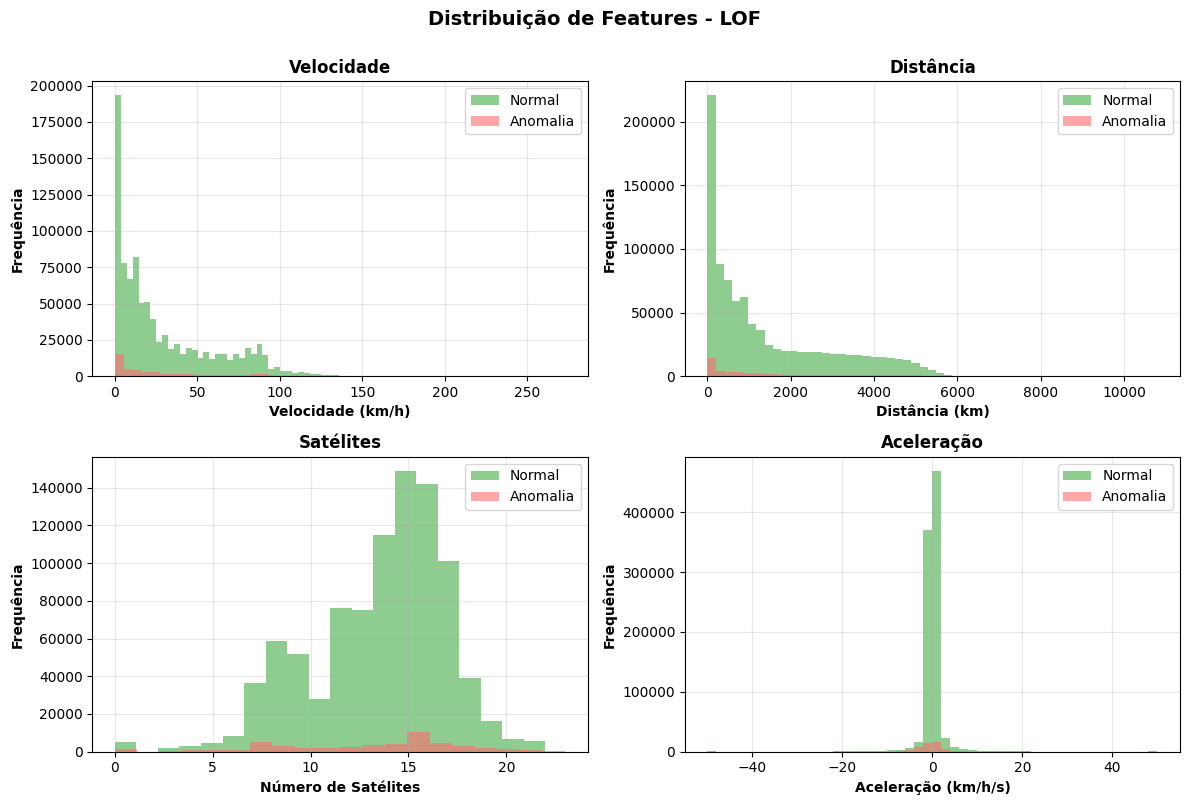


✓ Gráficos de distribuição LOF exibidos


In [12]:
# CÉLULA 12: DISTRIBUIÇÃO DE FEATURES - LOF
# ============================================================================
print("CÉLULA 12: Distribuição de Features - LOF")
print("=" * 80)

anomalias_lof_df = df_encoded[df_encoded['lof_prediction'] == -1]
normais_lof_df = df_encoded[df_encoded['lof_prediction'] == 1]

print(f"\nEstatísticas LOF - Anomalias:")
print(f"  Speed média: {anomalias_lof_df['speed'].mean():.2f} km/h")
print(f"  Speed máxima: {anomalias_lof_df['speed'].max():.2f} km/h")
print(f"  Distância média: {anomalias_lof_df['distancia_km'].mean():.4f} km")
print(f"  Aceleração média: {anomalias_lof_df['aceleracao'].mean():.2f} km/h/s")
print(f"  Satélites média: {anomalias_lof_df['satellites'].mean():.1f}")
print(f"  Inconsistência status: {anomalias_lof_df['inconsistencia_status'].sum():,}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribuição de Features - LOF', fontsize=14, fontweight='bold', y=1.00)

# Speed
axes[0, 0].hist(normais_lof_df['speed'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[0, 0].hist(anomalias_lof_df['speed'], bins=50, color='#FF6B6B', alpha=0.6, label='Anomalia')
axes[0, 0].set_xlabel('Velocidade (km/h)', fontweight='bold')
axes[0, 0].set_ylabel('Frequência', fontweight='bold')
axes[0, 0].set_title('Velocidade', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distância
axes[0, 1].hist(normais_lof_df['distancia_km'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[0, 1].hist(anomalias_lof_df['distancia_km'], bins=50, color='#FF6B6B', alpha=0.6, label='Anomalia')
axes[0, 1].set_xlabel('Distância (km)', fontweight='bold')
axes[0, 1].set_ylabel('Frequência', fontweight='bold')
axes[0, 1].set_title('Distância', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Satélites
axes[1, 0].hist(normais_lof_df['satellites'], bins=20, color='#44AA44', alpha=0.6, label='Normal')
axes[1, 0].hist(anomalias_lof_df['satellites'], bins=20, color='#FF6B6B', alpha=0.6, label='Anomalia')
axes[1, 0].set_xlabel('Número de Satélites', fontweight='bold')
axes[1, 0].set_ylabel('Frequência', fontweight='bold')
axes[1, 0].set_title('Satélites', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Aceleração
axes[1, 1].hist(normais_lof_df['aceleracao'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[1, 1].hist(anomalias_lof_df['aceleracao'], bins=50, color='#FF6B6B', alpha=0.6, label='Anomalia')
axes[1, 1].set_xlabel('Aceleração (km/h/s)', fontweight='bold')
axes[1, 1].set_ylabel('Frequência', fontweight='bold')
axes[1, 1].set_title('Aceleração', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✓ Gráficos de distribuição LOF exibidos")

CÉLULA 13: Distribuição de Features - Isolation Forest

Estatísticas Isolation Forest - Anomalias:
  Speed média: 13.96 km/h
  Speed máxima: 175.00 km/h
  Distância média: 2597.7241 km
  Aceleração média: -1.01 km/h/s
  Satélites média: 11.0
  Inconsistência status: 334


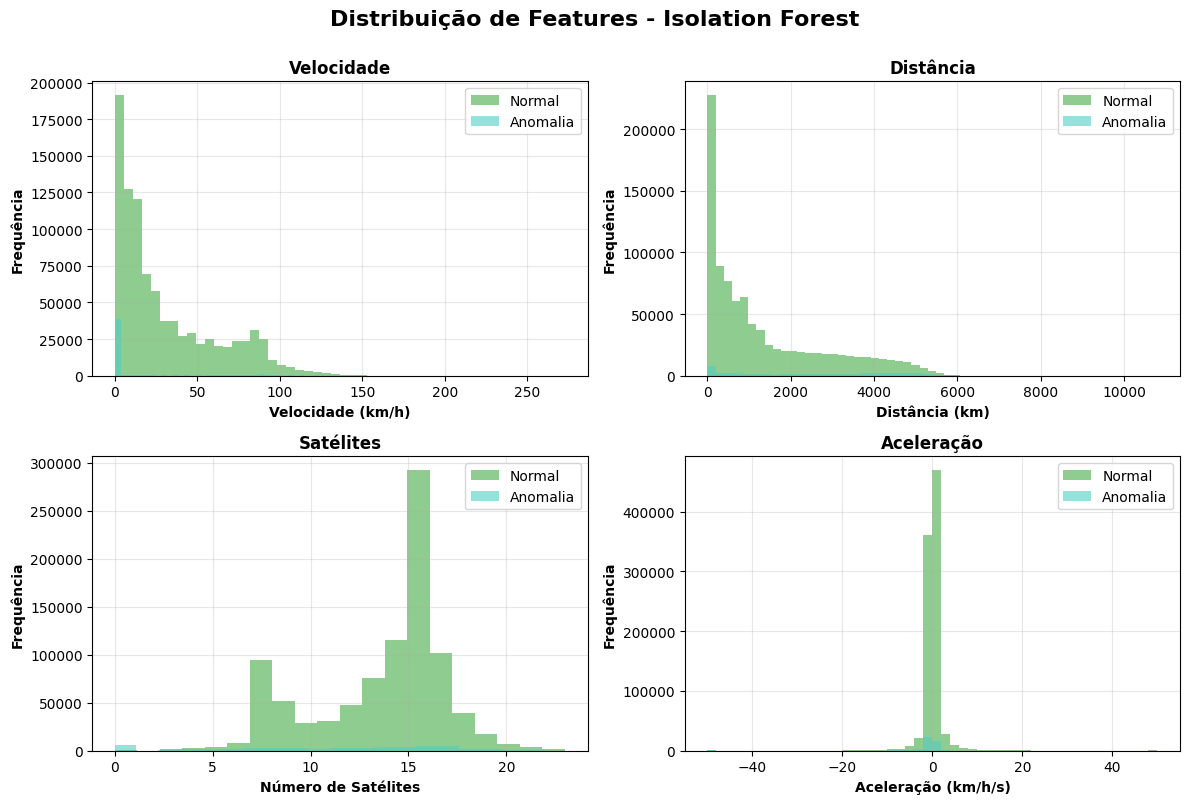


✓ Gráficos de distribuição Isolation Forest exibidos


In [13]:
# CÉLULA 13: DISTRIBUIÇÃO DE FEATURES - ISOLATION FOREST
# ============================================================================
print("CÉLULA 13: Distribuição de Features - Isolation Forest")
print("=" * 80)

anomalias_iso_df = df_encoded[df_encoded['iso_prediction'] == -1]
normais_iso_df = df_encoded[df_encoded['iso_prediction'] == 1]

print(f"\nEstatísticas Isolation Forest - Anomalias:")
print(f"  Speed média: {anomalias_iso_df['speed'].mean():.2f} km/h")
print(f"  Speed máxima: {anomalias_iso_df['speed'].max():.2f} km/h")
print(f"  Distância média: {anomalias_iso_df['distancia_km'].mean():.4f} km")
print(f"  Aceleração média: {anomalias_iso_df['aceleracao'].mean():.2f} km/h/s")
print(f"  Satélites média: {anomalias_iso_df['satellites'].mean():.1f}")
print(f"  Inconsistência status: {anomalias_iso_df['inconsistencia_status'].sum():,}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribuição de Features - Isolation Forest', fontsize=16, fontweight='bold', y=1.00)

# Speed
axes[0, 0].hist(normais_iso_df['speed'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[0, 0].hist(anomalias_iso_df['speed'], bins=50, color='#4ECDC4', alpha=0.6, label='Anomalia')
axes[0, 0].set_xlabel('Velocidade (km/h)', fontweight='bold')
axes[0, 0].set_ylabel('Frequência', fontweight='bold')
axes[0, 0].set_title('Velocidade', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distância
axes[0, 1].hist(normais_iso_df['distancia_km'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[0, 1].hist(anomalias_iso_df['distancia_km'], bins=50, color='#4ECDC4', alpha=0.6, label='Anomalia')
axes[0, 1].set_xlabel('Distância (km)', fontweight='bold')
axes[0, 1].set_ylabel('Frequência', fontweight='bold')
axes[0, 1].set_title('Distância', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Satélites
axes[1, 0].hist(normais_iso_df['satellites'], bins=20, color='#44AA44', alpha=0.6, label='Normal')
axes[1, 0].hist(anomalias_iso_df['satellites'], bins=20, color='#4ECDC4', alpha=0.6, label='Anomalia')
axes[1, 0].set_xlabel('Número de Satélites', fontweight='bold')
axes[1, 0].set_ylabel('Frequência', fontweight='bold')
axes[1, 0].set_title('Satélites', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Aceleração
axes[1, 1].hist(normais_iso_df['aceleracao'], bins=50, color='#44AA44', alpha=0.6, label='Normal')
axes[1, 1].hist(anomalias_iso_df['aceleracao'], bins=50, color='#4ECDC4', alpha=0.6, label='Anomalia')
axes[1, 1].set_xlabel('Aceleração (km/h/s)', fontweight='bold')
axes[1, 1].set_ylabel('Frequência', fontweight='bold')
axes[1, 1].set_title('Aceleração', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✓ Gráficos de distribuição Isolation Forest exibidos")

CÉLULA 14: Comparação de Scores


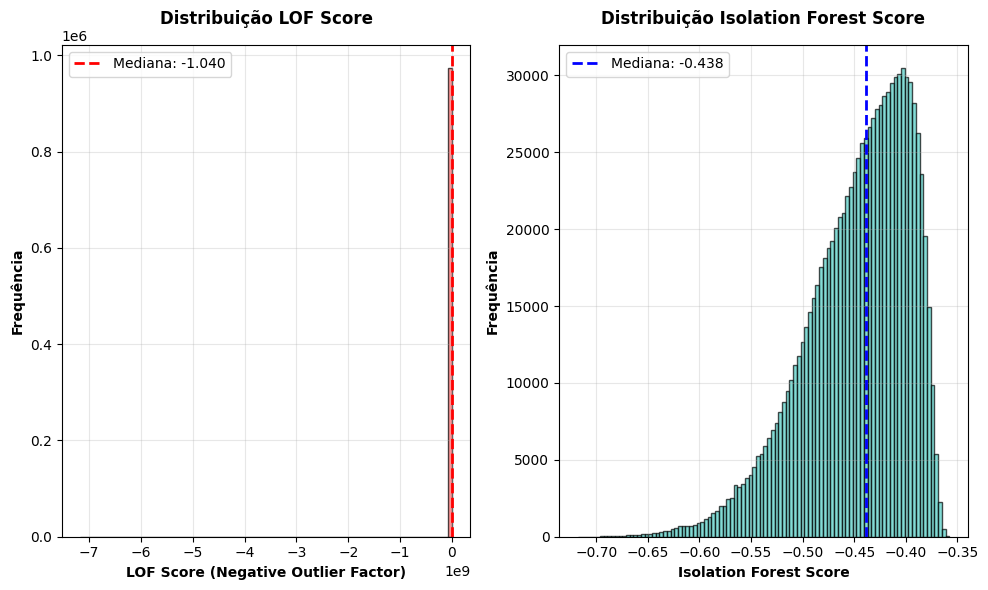

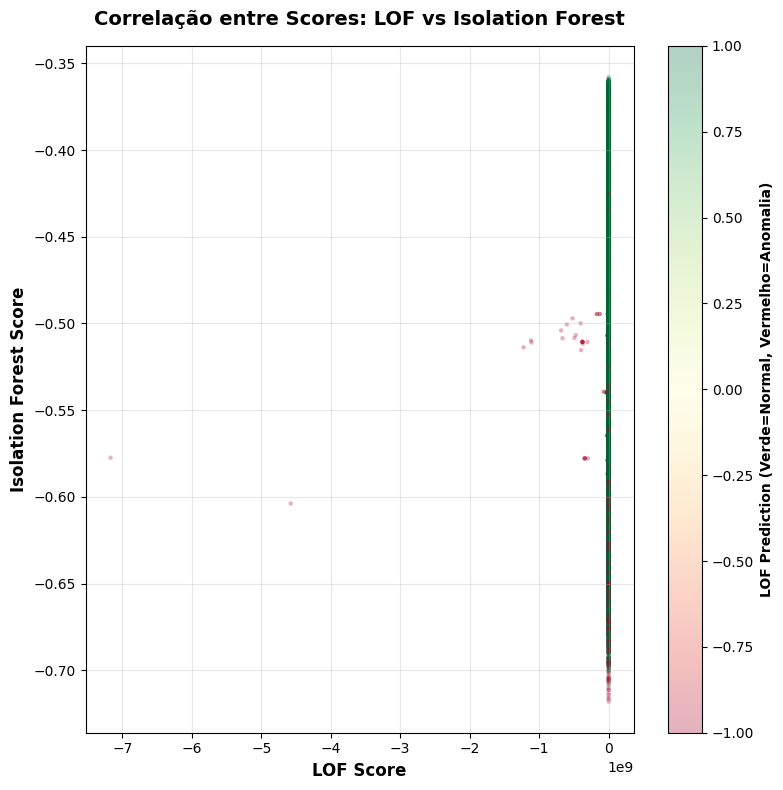


✓ Gráficos de scores exibidos

Correlação entre LOF Score e ISO Score: 0.006


In [14]:
# CÉLULA 14: COMPARAÇÃO SIDE-BY-SIDE DE SCORES
# ============================================================================
print("CÉLULA 14: Comparação de Scores")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# LOF Scores
axes[0].hist(df_encoded['lof_score'], bins=100, color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0].axvline(df_encoded['lof_score'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Mediana: {df_encoded["lof_score"].median():.3f}')
axes[0].set_xlabel('LOF Score (Negative Outlier Factor)', fontweight='bold')
axes[0].set_ylabel('Frequência', fontweight='bold')
axes[0].set_title('Distribuição LOF Score', fontweight='bold', pad=15)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Isolation Forest Scores
axes[1].hist(df_encoded['iso_score'], bins=100, color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].axvline(df_encoded['iso_score'].median(), color='blue', linestyle='--', 
                linewidth=2, label=f'Mediana: {df_encoded["iso_score"].median():.3f}')
axes[1].set_xlabel('Isolation Forest Score', fontweight='bold')
axes[1].set_ylabel('Frequência', fontweight='bold')
axes[1].set_title('Distribuição Isolation Forest Score', fontweight='bold', pad=15)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot: LOF vs ISO scores
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(df_encoded['lof_score'], df_encoded['iso_score'], 
                     c=df_encoded['lof_prediction'], cmap='RdYlGn', 
                     alpha=0.3, s=10, edgecolors='none')
ax.set_xlabel('LOF Score', fontweight='bold', fontsize=12)
ax.set_ylabel('Isolation Forest Score', fontweight='bold', fontsize=12)
ax.set_title('Correlação entre Scores: LOF vs Isolation Forest', fontweight='bold', fontsize=14, pad=15)
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('LOF Prediction (Verde=Normal, Vermelho=Anomalia)', fontweight='bold')
plt.tight_layout()
plt.show()
print("\n✓ Gráficos de scores exibidos")

# Correlação entre scores
corr_scores = np.corrcoef(df_encoded['lof_score'], df_encoded['iso_score'])[0, 1]
print(f"\nCorrelação entre LOF Score e ISO Score: {corr_scores:.3f}")

In [15]:
# CÉLULA 15: SALVAR RESULTADOS
# ============================================================================
print("CÉLULA 15: Salvando Resultados")
print("=" * 80)

# Dataset completo com ambos os modelos
df_encoded.to_csv('/kaggle/working/dados_lof_iso_completo.csv', index=False)
print("\n✓ Dataset completo: dados_lof_iso_completo.csv")

# Anomalias detectadas por LOF
anomalias_lof_export = df_encoded[df_encoded['lof_prediction'] == -1].sort_values('lof_score')
anomalias_lof_export.to_csv('/kaggle/working/anomalias_lof.csv', index=False)
print("✓ Anomalias LOF: anomalias_lof.csv")

# Anomalias detectadas por Isolation Forest
anomalias_iso_export = df_encoded[df_encoded['iso_prediction'] == -1].sort_values('iso_score')
anomalias_iso_export.to_csv('/kaggle/working/anomalias_iso.csv', index=False)
print("✓ Anomalias ISO: anomalias_iso.csv")

# Anomalias detectadas por AMBOS
anomalias_ambos = df_encoded[
    (df_encoded['lof_prediction'] == -1) & (df_encoded['iso_prediction'] == -1)
].sort_values('lof_score')
anomalias_ambos.to_csv('/kaggle/working/anomalias_consenso.csv', index=False)
print("✓ Anomalias Consenso (ambos): anomalias_consenso.csv")

# Resumo comparativo
resumo = pd.DataFrame({
    'Métrica': [
        'Veículos Totais',
        'Registros Totais',
        'Features Utilizadas',
        '---LOF---',
        'Anomalias LOF',
        'Taxa Anomalias LOF (%)',
        'Tempo LOF (s)',
        'Velocidade LOF (reg/s)',
        '---Isolation Forest---',
        'Anomalias ISO',
        'Taxa Anomalias ISO (%)',
        'Tempo ISO (s)',
        'Velocidade ISO (reg/s)',
        'Speedup ISO vs LOF',
        '---Comparação---',
        'Concordância (%)',
        'Ambos Anomalia',
        'Apenas LOF',
        'Apenas ISO',
        'Correlação Scores'
    ],
    'Valor': [
        f"{df_encoded['veiculo'].nunique():,}",
        f"{len(df_encoded):,}",
        len(FEATURES_FINAIS),
        '',
        f"{anomalias_lof:,}",
        f"{pct_lof:.2f}%",
        f"{tempo_lof:.2f}",
        f"{len(df_encoded)/tempo_lof:,.0f}",
        '',
        f"{anomalias_iso:,}",
        f"{pct_iso:.2f}%",
        f"{tempo_iso:.2f}",
        f"{len(df_encoded)/tempo_iso:,.0f}",
        f"{tempo_lof/tempo_iso:.1f}x",
        '',
        f"{pct_concordancia:.2f}%",
        f"{ambos_anomalia:,}",
        f"{apenas_lof:,}",
        f"{apenas_iso:,}",
        f"{corr_scores:.3f}"
    ]
})

resumo.to_csv('/kaggle/working/resumo_comparativo.csv', index=False)
print("✓ Resumo: resumo_comparativo.csv")

print(f"\n{resumo.to_string(index=False)}")

CÉLULA 15: Salvando Resultados

✓ Dataset completo: dados_lof_iso_completo.csv
✓ Anomalias LOF: anomalias_lof.csv
✓ Anomalias ISO: anomalias_iso.csv
✓ Anomalias Consenso (ambos): anomalias_consenso.csv
✓ Resumo: resumo_comparativo.csv

               Métrica   Valor
       Veículos Totais  17,844
      Registros Totais 973,261
   Features Utilizadas      12
             ---LOF---        
         Anomalias LOF  48,663
Taxa Anomalias LOF (%)   5.00%
         Tempo LOF (s) 1802.61
Velocidade LOF (reg/s)     540
---Isolation Forest---        
         Anomalias ISO  48,663
Taxa Anomalias ISO (%)   5.00%
         Tempo ISO (s)   93.12
Velocidade ISO (reg/s)  10,452
    Speedup ISO vs LOF   19.4x
      ---Comparação---        
      Concordância (%)  91.63%
        Ambos Anomalia   7,915
            Apenas LOF  40,748
            Apenas ISO  40,748
     Correlação Scores   0.006


In [16]:
# CÉLULA 16: RELATÓRIO FINAL
# ============================================================================
print("CÉLULA 16: Relatório Final")
print("=" * 80)

relatorio = f"""
RELATÓRIO COMPARATIVO: LOF vs ISOLATION FOREST
{'='*80}

DATA/HORA: {pd.Timestamp.now()}

DATASET:
  • Veículos: {df_encoded['veiculo'].nunique():,}
  • Registros: {len(df_encoded):,}
  • Features: {len(FEATURES_FINAIS)}

MODELO 1: LOCAL OUTLIER FACTOR (LOF)
{'='*80}
  • Anomalias: {anomalias_lof:,} ({pct_lof:.2f}%)
  • Tempo: {tempo_lof:.2f}s
  • Velocidade: {len(df_encoded)/tempo_lof:,.0f} registros/s
  
  Top 3 Veículos:
{chr(10).join([f"    {i}. Veículo {v}: {anomalias_veiculo_lof[v]:,} anomalias" 
               for i, v in enumerate(anomalias_veiculo_lof.head(3).index, 1)])}

MODELO 2: ISOLATION FOREST
{'='*80}
  • Anomalias: {anomalias_iso:,} ({pct_iso:.2f}%)
  • Tempo: {tempo_iso:.2f}s
  • Velocidade: {len(df_encoded)/tempo_iso:,.0f} registros/s
  • Speedup: {tempo_lof/tempo_iso:.1f}x mais rápido que LOF
  
  Top 3 Veículos:
{chr(10).join([f"    {i}. Veículo {v}: {anomalias_veiculo_iso[v]:,} anomalias" 
               for i, v in enumerate(anomalias_veiculo_iso.head(3).index, 1)])}

COMPARAÇÃO ENTRE MODELOS
{'='*80}
  • Concordância Total: {pct_concordancia:.2f}%
  • Ambos detectaram anomalia: {ambos_anomalia:,}
  • Apenas LOF detectou: {apenas_lof:,}
  • Apenas ISO detectou: {apenas_iso:,}
  • Correlação de Scores: {corr_scores:.3f}

CONCLUSÕES
{'='*80}
  1. Isolation Forest é {tempo_lof/tempo_iso:.1f}x mais rápido
  2. Concordância de {pct_concordancia:.2f}% indica alta consistência
  3. {ambos_anomalia:,} anomalias detectadas por ambos (alta confiança)
  
ARQUIVOS GERADOS:
  • dados_lof_iso_completo.csv - Dataset completo
  • anomalias_lof.csv - Anomalias detectadas pelo LOF
  • anomalias_iso.csv - Anomalias detectadas pelo Isolation Forest
  • anomalias_consenso.csv - Anomalias detectadas por AMBOS
  • resumo_comparativo.csv - Resumo das métricas

{'='*80}
"""

with open('/kaggle/working/relatorio_comparativo.txt', 'w', encoding='utf-8') as f:
    f.write(relatorio)

print(relatorio)
print("\n✓ Relatório salvo: relatorio_comparativo.txt")

print("\n" + "=" * 80)
print("PIPELINE CONCLUÍDO COM SUCESSO!")

CÉLULA 16: Relatório Final

RELATÓRIO COMPARATIVO: LOF vs ISOLATION FOREST

DATA/HORA: 2025-10-29 14:18:15.255932

DATASET:
  • Veículos: 17,844
  • Registros: 973,261
  • Features: 12

MODELO 1: LOCAL OUTLIER FACTOR (LOF)
  • Anomalias: 48,663 (5.00%)
  • Tempo: 1802.61s
  • Velocidade: 540 registros/s
  
  Top 3 Veículos:
    1. Veículo 10002: 4 anomalias
    2. Veículo 10003: 3 anomalias
    3. Veículo 10004: 1 anomalias

MODELO 2: ISOLATION FOREST
  • Anomalias: 48,663 (5.00%)
  • Tempo: 93.12s
  • Velocidade: 10,452 registros/s
  • Speedup: 19.4x mais rápido que LOF
  
  Top 3 Veículos:
    1. Veículo 10000: 3 anomalias
    2. Veículo 10001: 2 anomalias
    3. Veículo 10002: 4 anomalias

COMPARAÇÃO ENTRE MODELOS
  • Concordância Total: 91.63%
  • Ambos detectaram anomalia: 7,915
  • Apenas LOF detectou: 40,748
  • Apenas ISO detectou: 40,748
  • Correlação de Scores: 0.006

CONCLUSÕES
  1. Isolation Forest é 19.4x mais rápido
  2. Concordância de 91.63% indica alta consistência
  